# 🚀 Meta Networks on Omniglot

**Welcome to this hands-on tutorial!** 👋

This notebook provides a complete implementation of Meta Networks for few-shot learning on the Omniglot dataset. Meta Networks learn to generate task-specific parameters through a meta-learner network, enabling rapid adaptation to new tasks.

## 🎯 Overview

Meta Networks is a meta-learning algorithm that uses a meta-learner to generate fast weights for rapid task adaptation. Unlike MAML which optimizes for a good initialization, Meta Networks learn to directly produce task-specific parameters.

### ✨ Key Features:
- **5-way 1-shot learning**: Classify 5 characters with only 1 example per class 🎯
- **Fast weight generation**: Meta-learner produces task-specific parameters ⚡
- **Meta-learner architecture**: Uses U, V matrices and embedding vector e 🧠
- **Modular implementation**: Clean, reusable code structure 🔧

### 📊 Dataset:
The Omniglot dataset contains 1,623 different handwritten characters from 50 different alphabets, with 20 examples per character. Often called the "MNIST of few-shot learning"!

### 📖 References:
- [Meta Networks Paper](https://arxiv.org/abs/1703.00837) - Munkhdalai & Yu, 2017
- [Omniglot Dataset](https://github.com/brendenlake/omniglot)

---

Let's dive in! 🏊‍♂️

## 1️⃣ Import Dependencies

Import necessary libraries for implementing Meta Networks, data processing, and visualization. 📦

In [1]:
import sys
sys.path.append('/mnt/c/meta-learning-from-scratch')

import torch
from torch.utils.data import DataLoader
import numpy as np

# Import from repository utilities
from utils.load_omniglot import OmniglotDataset, OmniglotTaskDataset
from evaluation.eval_visualization import plot_evaluation_results, plot_training_progress

# Import Meta Network implementation
from algorithms.eb_meta_network import MetaNetwork, train_meta_network, evaluate_meta_network

## 2️⃣ Dataset Loading 🗂️

We use the existing dataset utilities from `utils/load_omniglot.py`:

### OmniglotDataset
Loads all character classes from the Omniglot dataset. Each character class contains approximately 20 handwritten examples. 📝

### OmniglotTaskDataset
Generates N-way K-shot learning tasks by randomly sampling character classes and splitting their examples into support and query sets. 🎲

**Task Structure:**
- **Support Set** 📚: K examples per class (for meta-learner to generate fast weights)
- **Query Set** 🧪: Additional examples per class (for evaluation)

These are the same dataset classes used in MAML training!

In [2]:
# Create a sample dataset for visualization
# Note: Update the path according to your Kaggle input
sample_data_path = "/mnt/c/meta-learning-from-scratch/omniglot/images_background"

print("🔄 Loading a sample of the Omniglot dataset...")
sample_dataset = OmniglotDataset(sample_data_path)

print(f"\n✅ Dataset loaded successfully!")
print(f"📊 Total character classes: {len(sample_dataset)}")

# Create a sample task dataset
print("\n🎲 Creating sample tasks...")
sample_task_dataset = OmniglotTaskDataset(
    sample_dataset, 
    n_way=5,      # 5 different characters per task
    k_shot=1,     # 1 example per character for training (support)
    k_query=5,    # 5 examples per character for testing (query)
    num_tasks=10  # Just 10 tasks for demonstration
)

print("✅ Task dataset created!")
print(f"📦 Number of tasks: {len(sample_task_dataset)}")

🔄 Loading a sample of the Omniglot dataset...
Loading character paths...


Processing alphabets: 100%|██████████| 30/30 [00:01<00:00, 19.47it/s]

Found 964 character classes

✅ Dataset loaded successfully!
📊 Total character classes: 964

🎲 Creating sample tasks...
✅ Task dataset created!
📦 Number of tasks: 10


### 🎯 Understanding the Data

**Key Observations:** 
- 📝 Each character has ~20 handwritten variations from different people
- 🎲 Tasks randomly sample 5 characters (5-way)
- 📚 Support set: 1 example per character (1-shot) - used for adaptation
- 🧪 Query set: Multiple examples per character - used for evaluation
- 🌍 Characters come from 50 different alphabets worldwide!

This diversity makes Omniglot perfect for testing meta-learning algorithms! 🚀

---

Now let's move on to building our neural network architecture! 🧠

## 3️⃣ Neural Network Architecture 🧠

The Meta Network implementation is in `EB_Meta_Network.py` and consists of three main components:

**EmbeddingNetwork (Base Feature Extractor):** 🏗️
- 4 convolutional layers (each with 64 filters, 3×3 kernel)
- Batch normalization after each conv layer
- Max pooling (2×2) reduces spatial dimensions
- Final FC layer outputs fixed-dimensional embeddings
- Input: 105×105 grayscale images 🖼️
- Output: Feature vectors (embedding dimension: 64)

**MetaLearner (Fast Weight Generator):** 🎯
- Learns three key parameters: U, V matrices and e vector
- **U Matrix** (hidden_dim × embedding_dim): Projects support embeddings
- **V Matrix** (hidden_dim × embedding_dim): Projects query embeddings  
- **e Vector** (hidden_dim): Base embedding capturing task structure
- Generates task-specific classifier weights from support set

**MetaNetwork (Complete System):** 🔄
- Combines EmbeddingNetwork and MetaLearner
- End-to-end trainable system
- Learns to rapidly generate classifiers for new tasks

All classes are imported from `EB_Meta_Network.py`!

## 4️⃣ Verify Setup 🔧

Let's verify that all components are properly imported and create a test model to check the architecture! 💎

**What we're checking:** ✨
- Meta Network model initialization
- Parameter shapes (U, V, e matrices)
- Total trainable parameters
- Device placement (CPU/GPU)

The implementation uses:
- `EmbeddingNetwork` from `EB_Meta_Network.py` 
- `MetaLearner` from `EB_Meta_Network.py`
- `MetaNetwork` from `EB_Meta_Network.py`
- Training and evaluation utilities from repository

In [3]:
# Verify Meta Network setup with a test model ✅
print("Setting up test Meta Network model... 🔧")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_model = MetaNetwork(embedding_dim=64, hidden_dim=128, num_classes=5).to(device)

print(f"✅ Meta Network created on {device}")
print(f"   Embedding network output: {test_model.embedding_network.fc.out_features} dims")
print(f"   Meta-learner U matrix: {test_model.meta_learner.U.shape}")
print(f"   Meta-learner V matrix: {test_model.meta_learner.V.shape}")
print(f"   Meta-learner e vector: {test_model.meta_learner.e.shape}")
print(f"\n✅ Total trainable parameters: {sum(p.numel() for p in test_model.parameters() if p.requires_grad):,}")
print("Ready to train! 🚀")

Setting up test Meta Network model... 🔧
✅ Meta Network created on cuda
   Embedding network output: 64 dims
   Meta-learner U matrix: torch.Size([128, 64])
   Meta-learner V matrix: torch.Size([128, 64])
   Meta-learner e vector: torch.Size([128])

✅ Total trainable parameters: 275,968
Ready to train! 🚀


## 5️⃣ Train Meta Network 🏋️‍♂️

Time to train our Meta Network model on the Omniglot training set! The meta-learner will learn to generate task-specific fast weights! ✨

**Training Configuration:** ⚙️
- 5-way 1-shot tasks 🎯
- 2000 training tasks 📚
- Batch size: 4 tasks per update
- Learning rate: 0.001 (for U, V, e and embedding network)
- Meta-learner parameters: U (128×64), V (128×64), e (128)

**How it works:** 🔄
1. Embedding network extracts features from images
2. Meta-learner uses U, V, e to generate task-specific classifier
3. All parameters updated jointly via backpropagation

**Expected Results:** 📈
- Training loss should decrease over time
- Final loss typically around 0.3-0.8
- Training time: ~10-30 minutes on GPU ⏱️

Grab a coffee! ☕ This might take a while...

In [5]:
# Setup data path and create task dataset
data_path = "/mnt/c/meta-learning-from-scratch/omniglot/images_background"

print("Loading Omniglot training dataset...")
omniglot_dataset = OmniglotDataset(data_path)

print("Creating task dataset...")
task_dataset = OmniglotTaskDataset(
    omniglot_dataset, 
    n_way=5, 
    k_shot=1, 
    k_query=15, 
    num_tasks=2000
)

task_dataloader = DataLoader(
    task_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=6,
    prefetch_factor=4,
    pin_memory=True
)

# Create Meta Network model for training
model = MetaNetwork(embedding_dim=64, hidden_dim=128, num_classes=5, dropout_rates=[0.1, 0.1, 0.1]).to(device)

print(f"\n🧠 Meta Network Architecture:")
print(f"   Embedding dimension: 64")
print(f"   Hidden dimension: 128")
print(f"   U matrix shape: {model.meta_learner.U.shape}")
print(f"   V matrix shape: {model.meta_learner.V.shape}")
print(f"   e vector shape: {model.meta_learner.e.shape}")

# Train Meta Network using the function from eb_meta_network.py
print("\nStarting Meta Network training...")
model, optimizer, losses = train_meta_network(
    model=model,
    task_dataloader=task_dataloader,
    learning_rate=0.001
)

Loading Omniglot training dataset...
Loading character paths...


Processing alphabets: 100%|██████████| 30/30 [00:01<00:00, 19.22it/s]


Found 964 character classes
Creating task dataset...

🧠 Meta Network Architecture:
   Embedding dimension: 64
   Hidden dimension: 128
   U matrix shape: torch.Size([128, 64])
   V matrix shape: torch.Size([128, 64])
   e vector shape: torch.Size([128])

Starting Meta Network training...
Using device: cuda
Starting Meta Network training...
Learning rate: 0.001
Optimizer: Adam
Meta-learner parameters: U (torch.Size([128, 64])), V (torch.Size([128, 64])), e (torch.Size([128]))


Training:  80%|████████  | 100/125 [02:00<00:26,  1.06s/it, Loss=0.4612, Avg=0.5161, Best=0.5213]

Step 100: Loss=0.7639


Training: 100%|██████████| 125/125 [02:33<00:00,  1.23s/it, Loss=0.4148, Avg=0.4306, Best=0.4367]


Training completed! Final loss: 0.5899


## 6️⃣ Training Progress Visualization 📊

Let's visualize how well our training went! We use the `plot_training_progress()` function from `utils/evaluate.py` - the same visualization used for MAML! 📈

This shows:
- Raw training loss over time
- Smoothed loss curve (moving average)
- Loss distribution histogram

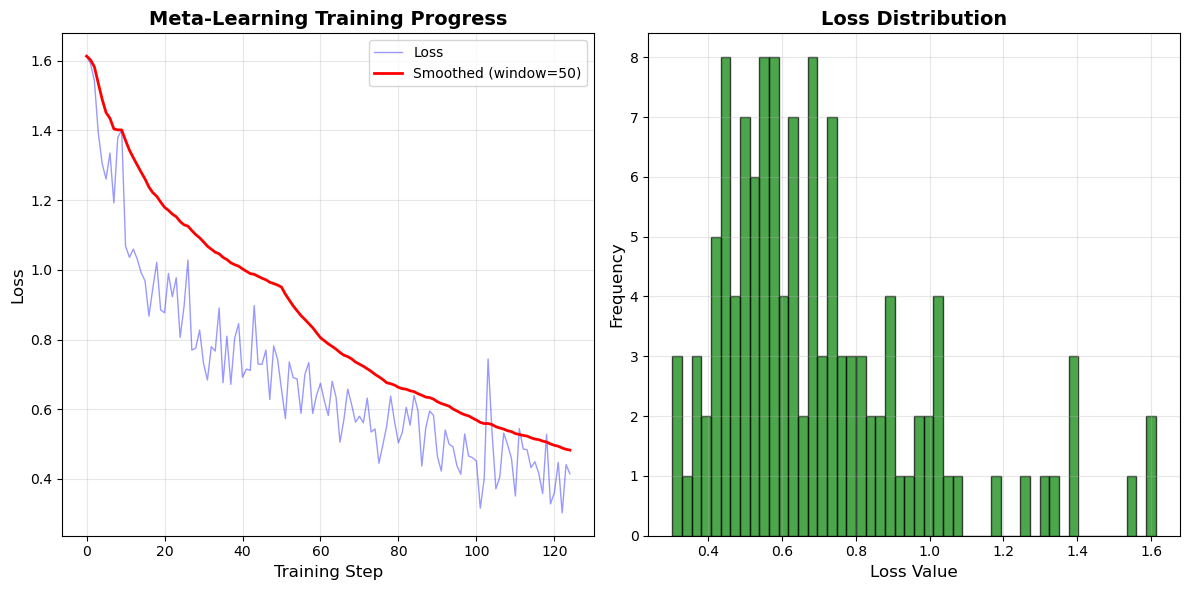


Training Statistics:
   Total steps: 125
   Initial loss (first 10): 1.4015
   Final loss (last 100): 0.5899
   Improvement: 0.8116
   Min loss: 0.3028
   Max loss: 1.6130


In [6]:
# Visualize training progress
plot_training_progress(losses, window_size=50)

## 7️⃣ Evaluate on Test Set 🧪

The moment of truth! Let's evaluate our trained Meta Network on completely unseen character classes! 🎭

**Key Difference from MAML:** Unlike MAML which requires gradient-based adaptation steps, Meta Networks directly generate task-specific parameters from the support set in a single forward pass! 🚀

**Evaluation Process:** 📏
- Uses `evaluate_meta_network()` from `EB_Meta_Network.py`
- Visualizes results with `plot_evaluation_results()` from `utils/evaluate.py`
- Same visualization framework as MAML for easy comparison!

**What we measure:** 🎯
- ✅ **Accuracy** using meta-learner generated fast weights
- 📊 **No adaptation step needed** - the meta-learner does it all!
- 🎯 **Direct generalization** to new tasks

**Expected Performance (5-way 1-shot):** 
- Accuracy: 65-95% (competitive with MAML!)
- Single forward pass (very fast inference) ⚡
- Meta-learner (U, V, e) captures task structure 🧠

Loading Omniglot evaluation dataset... 📚
Loading character paths...


Processing alphabets: 100%|██████████| 20/20 [00:01<00:00, 15.16it/s]


Found 659 character classes
Creating evaluation task dataset... 🎲

Evaluating Meta Network on test set... 🧪
Note: No adaptation step needed - meta-learner generates fast weights directly!


Evaluating: 100%|██████████| 200/200 [02:08<00:00,  1.56it/s]



META NETWORK EVALUATION RESULTS
Tasks Evaluated: 200
Task Structure: 5-way classification

Performance:
   Average Accuracy: 0.7167 ± 0.1356
   Average Loss: 0.8858
   Random Baseline: ~0.2000

Task Distribution:
   Tasks with >50% accuracy: 186/200 (93.0%)
   Tasks with >80% accuracy: 62/200 (31.0%)
   Tasks with >90% accuracy: 14/200 (7.0%)

Generating evaluation plots... 🎨


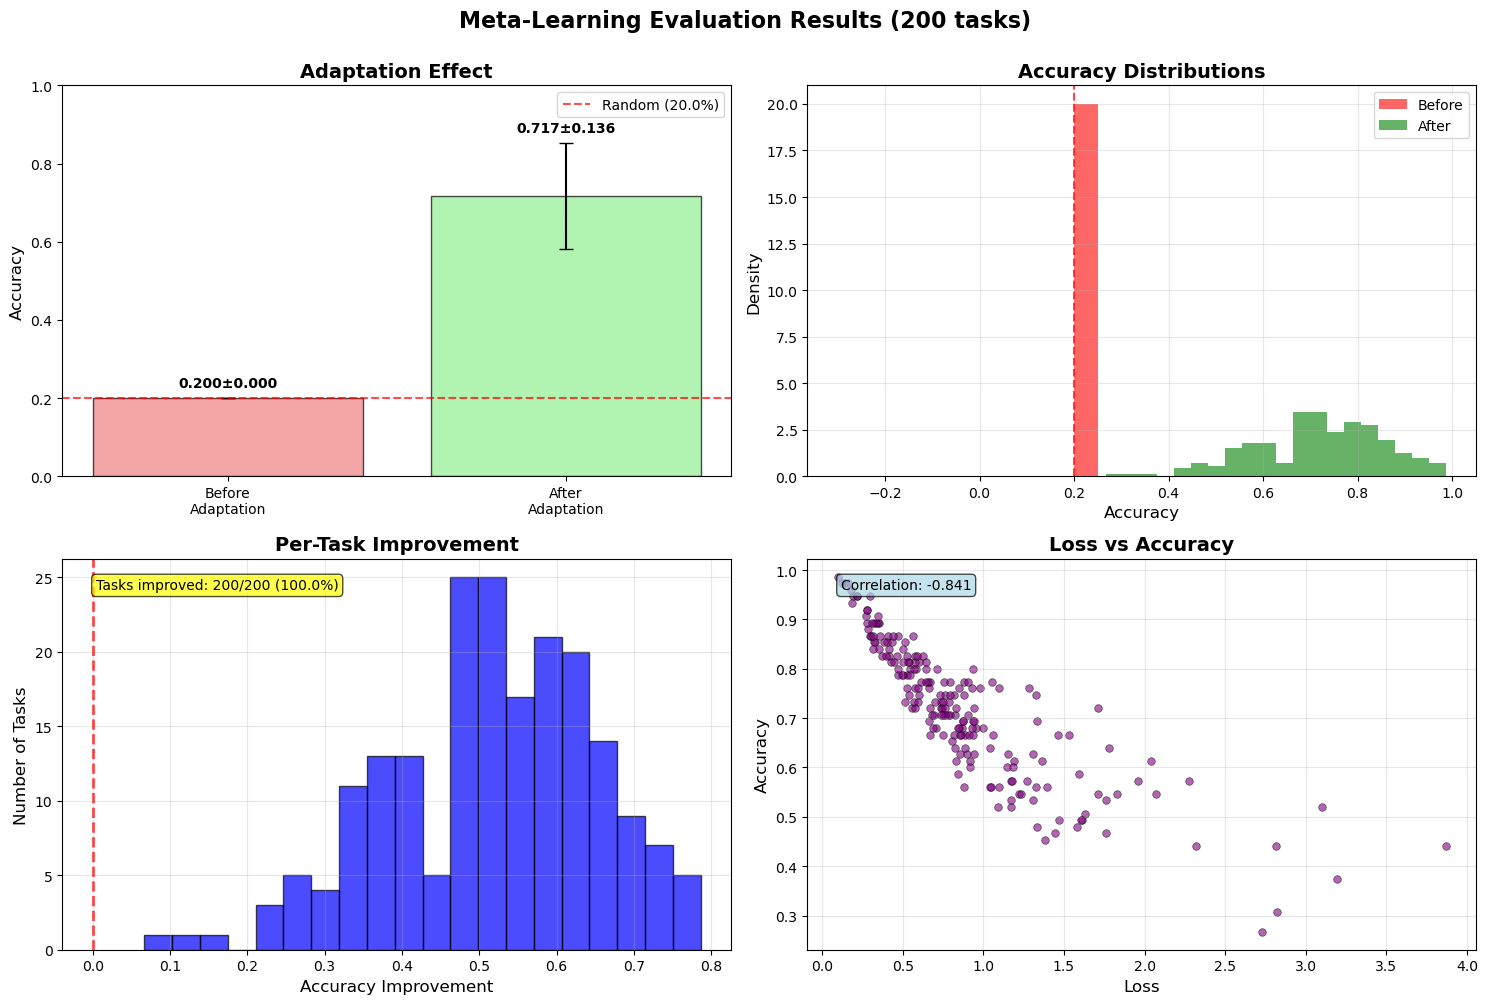


🏆 META NETWORK PERFORMANCE SUMMARY 🏆
✅ Overall Accuracy: 71.7% ± 13.6%
📉 Average Loss:     0.8858
🎲 Random Baseline:  20.0%

🎊 Congratulations! You've successfully trained Meta Networks! 🎊
💡 Key insight: Meta-learner (U, V, e) generates fast weights in one shot!


In [7]:
# [0.05, 0.1, 0.15]

# Load evaluation dataset 📂
print("Loading Omniglot evaluation dataset... 📚")
eval_data_path = "/mnt/c/meta-learning-from-scratch/omniglot/images_evaluation"
eval_dataset = OmniglotDataset(eval_data_path)

print("Creating evaluation task dataset... 🎲")
eval_task_dataset = OmniglotTaskDataset(
    eval_dataset, 
    n_way=5, 
    k_shot=1, 
    k_query=15, 
    num_tasks=200
)

eval_dataloader = DataLoader(
    eval_task_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0
)

# Run evaluation using the function from eb_meta_network.py 🏃‍♂️
print("\nEvaluating Meta Network on test set... 🧪")
print("Note: No adaptation step needed - meta-learner generates fast weights directly!")
eval_results = evaluate_meta_network(
    model=model,
    eval_dataloader=eval_dataloader,
    num_classes=5,
    verbose=True
)

# Visualize results using utils.evaluate 📊
print("\nGenerating evaluation plots... 🎨")
task_improvements = plot_evaluation_results(eval_results)

# Print summary 🎉
print("\n" + "="*70)
print("🏆 META NETWORK PERFORMANCE SUMMARY 🏆")
print("="*70)
print(f"✅ Overall Accuracy: {eval_results['after_adaptation_accuracy']:.1%} ± {eval_results['after_adaptation_std']:.1%}")
print(f"📉 Average Loss:     {np.mean(eval_results['all_losses']):.4f}")
print(f"🎲 Random Baseline:  {eval_results['random_baseline']:.1%}")
print("="*70)
print("\n🎊 Congratulations! You've successfully trained Meta Networks! 🎊")
print("💡 Key insight: Meta-learner (U, V, e) generates fast weights in one shot!")

## 🎓 Conclusion & Next Steps

Congratulations on completing this Meta Networks tutorial! 🎉

### What you've learned: ✨
- ✅ How to implement Meta Networks with learnable fast weights
- ✅ Understanding U, V matrices and embedding vector e
- ✅ Training meta-learner to generate task-specific parameters
- ✅ Direct parameter generation vs gradient-based adaptation

### Key Concepts: 🧠
- **U Matrix**: Projects support set embeddings to fast weights
- **V Matrix**: Projects query embeddings for classification
- **e Vector**: Base embedding capturing task structure
- **Fast Weights**: Task-specific parameters generated from support set

### Meta Networks vs MAML: ⚖️
- **Meta Networks**: Learn to generate parameters (U, V, e) ⚡
- **MAML**: Learn good initialization + gradient adaptation 🔄
- **Speed**: Meta Networks are faster at inference (no adaptation loop)
- **Flexibility**: Both achieve strong few-shot performance!

### Next Steps: 🚀
1. **Compare with MAML** - Run both algorithms and compare results
2. **Experiment with architectures** - Try different U, V, e dimensions
3. **Advanced variants** - Explore attention-based meta-learners
4. **Other datasets** - Apply to miniImageNet, CUB, or custom datasets
5. **Theoretical analysis** - Study what U, V, e learn during training

### Resources: 📚
- [Meta Networks Paper](https://arxiv.org/abs/1703.00837) - Munkhdalai & Yu, 2017
- [Omniglot Dataset](https://github.com/brendenlake/omniglot)

---

**If you found this tutorial helpful, please upvote! ⬆️**

Happy Meta-Learning! 🤖💡